In [86]:
%pip install -r requirements-notebook.txt

Note: you may need to restart the kernel to use updated packages.


In [87]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

# Load the model and feature extractor
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b1-finetuned-cityscapes-1024-1024")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b1-finetuned-cityscapes-1024-1024")


/Users/tommyluu/Documents/projects/mf-nerf/venv/lib/python3.12/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/Users/tommyluu/Documents/projects/mf-nerf/venv/lib/python3.12/site-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [88]:
# Define the class names and color palette from Cityscapes
CLASSES = [
    "road", "sidewalk", "building", "wall", "fence", "pole", "traffic light", "traffic sign", 
    "vegetation", "terrain", "sky", "person", "rider", "car", "truck", "bus", "train", 
    "motorcycle", "bicycle"
]
PALETTE = np.array([[128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156], [190, 153, 153], 
                    [153, 153, 153], [250, 170, 30], [220, 220, 0], [107, 142, 35], [152, 251, 152], 
                    [70, 130, 180], [220, 20, 60], [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100], 
                    [0, 80, 100], [0, 0, 230], [119, 11, 32]])


In [89]:
def load_image(image_path):
    """Load an image from a file or URL."""
    if image_path.startswith('http://') or image_path.startswith('https://'):
        return Image.open(requests.get(image_path, stream=True).raw).convert('RGB')
    else:
        return Image.open(image_path).convert('RGB')

0: road
1: sidewalk
2: building
4: fence
5: pole
6: traffic light
7: traffic sign
8: vegetation
10: sky
13: car


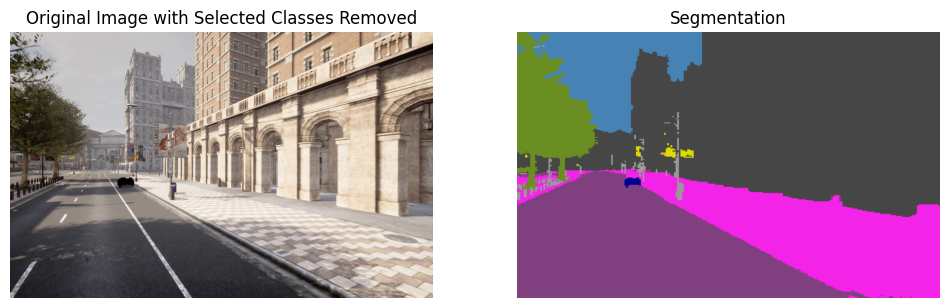

In [90]:
def segment_image(image_path):
    """Segment the image at the given path."""
    image = load_image(image_path)
    original_size = image.size  # Store original image size
    
    # Prepare the image
    inputs = feature_extractor(images=image, return_tensors="pt")
    
    # Perform segmentation
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = logits.argmax(dim=1).squeeze(0)  # Take the highest scoring pixel label at each location
    segmentation_image = predictions.detach().cpu().numpy()
    unique_labels = np.unique(segmentation_image)
    for label in unique_labels:
        print(f'\033[38;2;{PALETTE[label][0]};{PALETTE[label][1]};{PALETTE[label][2]}m{label}: {CLASSES[label]}\033[0m')
        
    # Rescale the segmentation map to the original image size    
    segmentation_resized = Image.fromarray(segmentation_image.astype(np.uint8))
    segmentation_resized = segmentation_resized.resize(original_size, Image.NEAREST)  # Resize to match original image
    
    # Map the segmentation
    segmentation_resized = np.array(segmentation_resized)
    segmentation_colored = PALETTE[segmentation_resized]
    
    # Remove classes that are vehicles or persons from the original image
    mask = np.isin(segmentation_resized, [11, 12, 13, 14, 15, 16, 17, 18], invert=True)  # Mask out selected classes
    image_array = np.array(image)
    image_array[~mask] = [0, 0, 0]  # Set masked areas to black
    
    # Display original and segmentation images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_array)
    plt.title('Original Image with Selected Classes Removed')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(segmentation_colored)
    plt.title('Segmentation')
    plt.axis('off')
    
    plt.show()

# Example usage
segment_image('test_img.png')
